In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import itertools

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_ = pd.read_csv("https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients.csv", index_col=0)
df_.head()

,全国地方公共団体コード,都道府県名,市区町村名,公表_年月日,曜日,発症_年月日,患者_居住地,患者_年代,患者_性別,患者_属性,患者_状態,患者_症状,患者_渡航歴の有無フラグ,備考,退院済フラグ
No,,,,,,,,,,,,,,,
1,130001,東京都,NaN,2020-01-24,金,NaN,湖北省武漢市,40代,男性,NaN,NaN,NaN,NaN,NaN,1.0
2,130001,東京都,NaN,2020-01-25,土,NaN,湖北省武漢市,30代,女性,NaN,NaN,NaN,NaN,NaN,1.0
3,130001,東京都,NaN,2020-01-30,木,NaN,湖南省長沙市,30代,女性,NaN,NaN,NaN,NaN,NaN,1.0
4,130001,東京都,NaN,2020-02-13,木,NaN,都内,70代,男性,NaN,NaN,NaN,NaN,NaN,NaN
5,130001,東京都,NaN,2020-02-14,金,NaN,都内,50代,女性,NaN,NaN,NaN,NaN,NaN,1.0


In [3]:
# 年月日で集計
s = df_['公表_年月日'].value_counts().sort_index()

df = pd.DataFrame({'date':pd.to_datetime(s.index), 'confirmed':s})

# 報告がない日は0埋めしておく
df = pd.merge(pd.DataFrame({'date': pd.date_range(df.iloc[0]['date'],
                                                  df.iloc[-1]['date'])}),
              df, how='left')
df['confirmed'] = df['confirmed'].fillna(0)
df = df.set_index('date', drop=False)

df.head()

,date,confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,2020-01-25,1.0
2020-01-26,2020-01-26,0.0
2020-01-27,2020-01-27,0.0
2020-01-28,2020-01-28,0.0


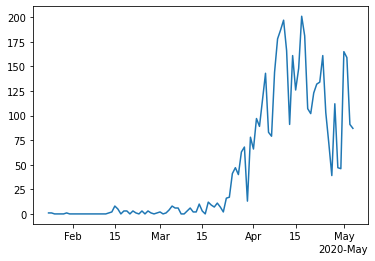

In [4]:
# 感染者数の推移をプロット

fig, ax = plt.subplots()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax.clear()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(df['date'], df['confirmed'])

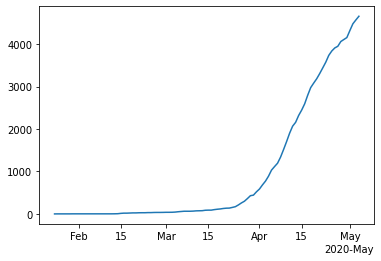

In [5]:
# 感染者数の累計をプロット

fig, ax = plt.subplots()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax.clear()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(df['date'], df['confirmed'].cumsum())

In [6]:
# AICが最小となるSARIMAモデルをグリッドサーチ

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

best_fit = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df['confirmed'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            if best_fit == None:
                best_fit = results
            elif results.aic < best_fit.aic:
                best_fit = results
        except: 
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 7) - AIC:1164.6139494773374
SARIMAX(0, 0, 0)x(0, 0, 1, 7) - AIC:1020.793244222198
SARIMAX(0, 0, 0)x(0, 0, 2, 7) - AIC:907.7309272052566
SARIMAX(0, 0, 0)x(0, 1, 0, 7) - AIC:933.9971478575485
SARIMAX(0, 0, 0)x(0, 1, 1, 7) - AIC:871.1558300578037
SARIMAX(0, 0, 0)x(0, 1, 2, 7) - AIC:807.1033901538992
SARIMAX(0, 0, 0)x(0, 2, 0, 7) - AIC:907.0022038899625
SARIMAX(0, 0, 0)x(0, 2, 1, 7) - AIC:818.5462067287899
SARIMAX(0, 0, 0)x(0, 2, 2, 7) - AIC:753.0483646725247
SARIMAX(0, 0, 0)x(1, 0, 0, 7) - AIC:944.6191101715813
SARIMAX(0, 0, 0)x(1, 0, 1, 7) - AIC:934.8346895333495
SARIMAX(0, 0, 0)x(1, 0, 2, 7) - AIC:868.8756102236426
SARIMAX(0, 0, 0)x(1, 1, 0, 7) - AIC:879.7496696525367
SARIMAX(0, 0, 0)x(1, 1, 1, 7) - AIC:872.7898246253471
SARIMAX(0, 0, 0)x(1, 1, 2, 7) - AIC:804.101282577747
SARIMAX(0, 0, 0)x(1, 2, 0, 7) - AIC:838.8536454450796
SARIMAX(0, 0, 0)x(1, 2, 1, 7) - AIC:819.226939118603
SARIMAX(0, 0, 0)x(1, 2, 2, 7) - AIC:755.0483629076411
SARIMAX(0, 0, 0)x(2, 0, 0, 7)

SARIMAX(0, 1, 2)x(2, 0, 1, 7) - AIC:794.9277267802742
SARIMAX(0, 1, 2)x(2, 0, 2, 7) - AIC:771.5854672704014
SARIMAX(0, 1, 2)x(2, 1, 0, 7) - AIC:742.5461781455849
SARIMAX(0, 1, 2)x(2, 1, 1, 7) - AIC:741.5422868430254
SARIMAX(0, 1, 2)x(2, 1, 2, 7) - AIC:718.7392934033485
SARIMAX(0, 1, 2)x(2, 2, 0, 7) - AIC:710.3716708300819
SARIMAX(0, 1, 2)x(2, 2, 1, 7) - AIC:696.8011722368258
SARIMAX(0, 1, 2)x(2, 2, 2, 7) - AIC:669.0838348337056
SARIMAX(0, 2, 0)x(0, 0, 0, 7) - AIC:1028.4346183805126
SARIMAX(0, 2, 0)x(0, 0, 1, 7) - AIC:963.1110744966314
SARIMAX(0, 2, 0)x(0, 0, 2, 7) - AIC:870.4239454474215
SARIMAX(0, 2, 0)x(0, 1, 0, 7) - AIC:986.3674469856188
SARIMAX(0, 2, 0)x(0, 1, 1, 7) - AIC:886.8025944586519
SARIMAX(0, 2, 0)x(0, 1, 2, 7) - AIC:815.0861411703481
SARIMAX(0, 2, 0)x(0, 2, 0, 7) - AIC:1012.38643125136
SARIMAX(0, 2, 0)x(0, 2, 1, 7) - AIC:862.4130975923979
SARIMAX(0, 2, 0)x(0, 2, 2, 7) - AIC:762.764141914288
SARIMAX(0, 2, 0)x(1, 0, 0, 7) - AIC:970.2097686078502
SARIMAX(0, 2, 0)x(1, 0, 1, 7)

SARIMAX(1, 0, 2)x(1, 0, 1, 7) - AIC:854.2275210931143
SARIMAX(1, 0, 2)x(1, 0, 2, 7) - AIC:790.4055959397233
SARIMAX(1, 0, 2)x(1, 1, 0, 7) - AIC:800.1826057861336
SARIMAX(1, 0, 2)x(1, 1, 1, 7) - AIC:796.345778907599
SARIMAX(1, 0, 2)x(1, 1, 2, 7) - AIC:724.6489037641938
SARIMAX(1, 0, 2)x(1, 2, 0, 7) - AIC:770.3051019415425
SARIMAX(1, 0, 2)x(1, 2, 1, 7) - AIC:740.4057085060546
SARIMAX(1, 0, 2)x(1, 2, 2, 7) - AIC:675.1201241039956
SARIMAX(1, 0, 2)x(2, 0, 0, 7) - AIC:800.9604526807731
SARIMAX(1, 0, 2)x(2, 0, 1, 7) - AIC:795.1938215819348
SARIMAX(1, 0, 2)x(2, 0, 2, 7) - AIC:780.5612654996539
SARIMAX(1, 0, 2)x(2, 1, 0, 7) - AIC:742.0360247643525
SARIMAX(1, 0, 2)x(2, 1, 1, 7) - AIC:740.9989871518668
SARIMAX(1, 0, 2)x(2, 1, 2, 7) - AIC:726.6455306375865
SARIMAX(1, 0, 2)x(2, 2, 0, 7) - AIC:709.3403764345592
SARIMAX(1, 0, 2)x(2, 2, 1, 7) - AIC:696.4632300904885
SARIMAX(1, 0, 2)x(2, 2, 2, 7) - AIC:677.1136662969428
SARIMAX(1, 1, 0)x(0, 0, 0, 7) - AIC:950.3496740126255
SARIMAX(1, 1, 0)x(0, 0, 1, 7)

SARIMAX(1, 2, 2)x(0, 0, 1, 7) - AIC:869.9796421868066
SARIMAX(1, 2, 2)x(0, 0, 2, 7) - AIC:776.8003331194079
SARIMAX(1, 2, 2)x(0, 1, 0, 7) - AIC:859.376779316935
SARIMAX(1, 2, 2)x(0, 1, 1, 7) - AIC:783.9683351267696
SARIMAX(1, 2, 2)x(0, 1, 2, 7) - AIC:726.3120217503151
SARIMAX(1, 2, 2)x(0, 2, 0, 7) - AIC:871.658939944316
SARIMAX(1, 2, 2)x(0, 2, 1, 7) - AIC:749.0984439269183
SARIMAX(1, 2, 2)x(0, 2, 2, 7) - AIC:670.1725326100623
SARIMAX(1, 2, 2)x(1, 0, 0, 7) - AIC:877.8340006211529
SARIMAX(1, 2, 2)x(1, 0, 1, 7) - AIC:855.6879848405935
SARIMAX(1, 2, 2)x(1, 0, 2, 7) - AIC:788.5167403696211
SARIMAX(1, 2, 2)x(1, 1, 0, 7) - AIC:785.7635742001495
SARIMAX(1, 2, 2)x(1, 1, 1, 7) - AIC:773.7464043588635
SARIMAX(1, 2, 2)x(1, 1, 2, 7) - AIC:716.4904270883054
SARIMAX(1, 2, 2)x(1, 2, 0, 7) - AIC:755.7615997033413
SARIMAX(1, 2, 2)x(1, 2, 1, 7) - AIC:721.0351979073695
SARIMAX(1, 2, 2)x(1, 2, 2, 7) - AIC:659.1711946762235
SARIMAX(1, 2, 2)x(2, 0, 0, 7) - AIC:794.7645334199348
SARIMAX(1, 2, 2)x(2, 0, 1, 7) 

SARIMAX(2, 1, 1)x(2, 0, 1, 7) - AIC:777.2847230250723
SARIMAX(2, 1, 1)x(2, 0, 2, 7) - AIC:779.0179434591574
SARIMAX(2, 1, 1)x(2, 1, 0, 7) - AIC:724.0450717072694
SARIMAX(2, 1, 1)x(2, 1, 1, 7) - AIC:723.5535821595604
SARIMAX(2, 1, 1)x(2, 1, 2, 7) - AIC:723.843179005955
SARIMAX(2, 1, 1)x(2, 2, 0, 7) - AIC:693.0302881083966
SARIMAX(2, 1, 1)x(2, 2, 1, 7) - AIC:678.1245479499754
SARIMAX(2, 1, 1)x(2, 2, 2, 7) - AIC:676.3293147182683
SARIMAX(2, 1, 2)x(0, 0, 0, 7) - AIC:921.8599834054412
SARIMAX(2, 1, 2)x(0, 0, 1, 7) - AIC:858.9816978239
SARIMAX(2, 1, 2)x(0, 0, 2, 7) - AIC:781.2088617838377
SARIMAX(2, 1, 2)x(0, 1, 0, 7) - AIC:860.6715110677001
SARIMAX(2, 1, 2)x(0, 1, 1, 7) - AIC:785.4554016302948
SARIMAX(2, 1, 2)x(0, 1, 2, 7) - AIC:728.0882569408262
SARIMAX(2, 1, 2)x(0, 2, 0, 7) - AIC:872.6898118979781
SARIMAX(2, 1, 2)x(0, 2, 1, 7) - AIC:753.6629850767055
SARIMAX(2, 1, 2)x(0, 2, 2, 7) - AIC:681.2178390057996
SARIMAX(2, 1, 2)x(1, 0, 0, 7) - AIC:858.1492226546584
SARIMAX(2, 1, 2)x(1, 0, 1, 7) - 

In [7]:
print(best_fit.summary().tables[0])

                                 Statespace Model Results                                
Dep. Variable:                         confirmed   No. Observations:                  102
Model:             SARIMAX(1, 2, 2)x(1, 2, 2, 7)   Log Likelihood                -322.586
Date:                           Tue, 05 May 2020   AIC                            659.171
Time:                                   01:16:30   BIC                            674.810
Sample:                               01-24-2020   HQIC                           665.376
                                    - 05-04-2020                                         
Covariance Type:                             opg                                         


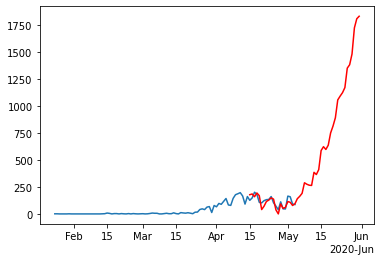

In [8]:


pred = best_fit.predict('2020-04-15', '2020-05-31')

fig, ax = plt.subplots()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax.clear()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(df['date'], df['confirmed'])
ax.plot(pred.index, pred, 'r')